***Public-AI***

# Additional. 합성곱 연산 최적화하기

### _Objective_
* CNN 모델을 연산할 때, 실제로는 For 구문으로 동작하는 것이 아닌, 4차원 행렬을 2차원으로 변환 후(im2col) 행렬곱 연산하는 방식으로 진행합니다.<br>
* 어떤 식으로 동작하는 지 배워보도록 하겠습니다.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets.cifar10 import load_data

### 데이터 셋 가져오기

In [2]:
(train_X, train_Y), (test_X, test_Y) = load_data()

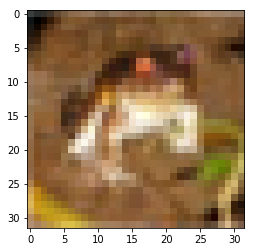

In [3]:
xs = train_X[0]

plt.imshow(xs)
plt.show()

<br><br>

# \[ 1. 실제 합성곱 연산의 동작 방식 \]

----
----
 
> *합성곱 연산은 3중 For구문의 형태로 구성되어 있습니다. 이렇게 구현된 경우, 속도가 매우 느려지는 이슈가 발생합니다.*<br>
> *이러한 이슈를 줄이기 위해, 4차원 행렬을 2차원으로 펼치는 작업을 거칩니다. 실제로 GPU 머신에서 돌아가는 방식이기도 합니다.*<br>

## 1. For 구문으로 합성곱 연산 구현하기
---


### (1) 필터 구성하기

필터의 형태는 (필터의 갯수, 필터의 높이, 필터의 폭, 입력 특징 맵의 채널 수)로 결정됩니다.<br>
아래와 같이 sobel 필터를 기준으로 설정해보도록 하겠습니다.

In [4]:
w_sobel = np.array([
    [[1,1,1],[0,0,0],[-1,-1,-1]],
    [[2,2,2],[0,0,0],[-2,-2,-2]],
    [[1,1,1],[0,0,0],[-1,-1,-1]]
])

h_sobel = np.array([
    [[1,1,1],[2,2,2],[1,1,1]],
    [[0,0,0],[0,0,0],[0,0,0]],
    [[-1,-1,-1],[-2,-2,-2],[-1,-1,-1]]
])

filters = np.stack([w_sobel,h_sobel])
filters.shape

(2, 3, 3, 3)

### (2) 합성곱 연산 적용하기

하나의 이미지를 가져오겠습니다. 

In [10]:
image = train_X[0]
print(image.shape)

(32, 32, 3)


In [14]:
%%timeit
output = np.zeros([30,30,2]) # valid padding, stride=1일때
for y in range(image.shape[0]-2):
    for x in range(image.shape[1]-2):
        patch = image[y:y+3,x:x+3]
        for k in range(len(filters)):
            output[y,x,k] = np.sum(patch * filters[k])


10.4 ms ± 48.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 2. im2col로 특징 맵을 펼치기
---

합성곱 연산을 원래대로 한다면, For 구문을 3중으로 짜야합니다. 이렇게 될 경우,<br>
연산의 성능이 크게 떨어집니다.<br>

이를 방지하기 위해 입력 데이터를 2차원의 벡터로 펼치는 작업을 우선 진행합니다.<br>


### (1) im2col 동작 구조

![Imgur](https://i.imgur.com/g4o3ffZ.png)

위와 같이 우리는 Stride 단위로 패치들을 하나씩 행 방향으로 쌓습니다.<br>
이렇게 쌓은 2차원 행렬은 Fully Connected Layer처럼<br>
아래와 같이, 행렬곱 연산이 가능해집니다.

![Imgur](https://i.imgur.com/LtkqENo.png)

In [16]:
def im2col(feature, filter_shape, stride=1):
    """다수의 입력 특징 맵을 입력받아 2차원 배열로 변환합니다.(평탄화).
    
    Parameters
    ----------
    feature : 4차원 배열 형태의 입력 데이터(배치 갯수, 높이, 폭, 채널 수)
    filter_shape : 필터의 크기 (필터의 높이, 필터의 폭, 필터의 갯수)
    stride : 스트라이드의 크기
    
    Returns
    -------
    col : 2차원 배열 (배치 갯수  * 출력의 높이 * 출력의 폭 * 필터의 갯수, 
                    필터의 높이 * 필터의 폭  * 채널 수)
    """
    batch_size, h_in, w_in, c_in = feature.shape
    filter_h, filter_w = filter_shape[:2]
    
    out_h = (h_in - filter_h)//stride + 1
    out_w = (w_in - filter_w)//stride + 1

    col = np.zeros((batch_size, filter_h, filter_w, out_h, out_w,c_in))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, y, x, :, :, :] = feature[:, y:y_max:stride, x:x_max:stride]

    col = (col
            .transpose(0, 3, 4, 1, 2, 5)
            .reshape(batch_size*out_h*out_w, -1))
    return col

def col2im(col, feature_shape, filter_shape, stride=1):
    """im2col과 반대로 동작하는 함수로, 2차원 배열을 받아 원래의 입력 특징 맵으로 복원합니다.
    
    Parameters
    ----------
    cols : 2차원 배열(입력 데이터)
    feature_shape : 특징맵의 본래 형태 (배치 갯수, 높이, 폭, 채널 수)
    filter_shape : 필터의 크기 (필터의 높이, 필터의 폭, 필터의 갯수)
    stride : 스트라이드의 크기
    
    Returns
    -------
    features : 변환된 입력 형태들
    """
    batch_size, h_in, w_in, c_in = feature_shape
    filter_h, filter_w = filter_shape[:2]
    
    out_h = (h_in - filter_h)//stride + 1
    out_w = (w_in - filter_w)//stride + 1
    col = (col
           .reshape(batch_size, out_h, out_w, filter_h, filter_w, c_in)
           .transpose(0,3,4,1,2,5))
    
    feature = np.zeros((batch_size, h_in, w_in, c_in))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            feature[:, y:y_max:stride, x:x_max:stride] = col[:, y, x, :, :, :]
    return feature

### (2) im2col 적용하기

im2col을 적용했을 때의 동작을 코드로 확인해 봅시다.

In [17]:
filter_shape = (h_f, w_f) = (3,3) # Filter의 크기를 (3,3)으로 둚

xs = train_X[:1]
print("Feature Map의 형태 : ",xs.shape)

col = im2col(xs,filter_shape)
print("col의 형태 : ",col.shape)

Feature Map의 형태 :  (1, 32, 32, 3)
col의 형태 :  (900, 27)


In [18]:
patch_1 = xs[:,:h_f,:w_f] # 첫번째 패치
patch_1

array([[[[59, 62, 63],
         [43, 46, 45],
         [50, 48, 43]],

        [[16, 20, 20],
         [ 0,  0,  0],
         [18,  8,  0]],

        [[25, 24, 21],
         [16,  7,  0],
         [49, 27,  8]]]], dtype=uint8)

In [19]:
col[0] # 첫번째 패치를 편것

array([59., 62., 63., 43., 46., 45., 50., 48., 43., 16., 20., 20.,  0.,
        0.,  0., 18.,  8.,  0., 25., 24., 21., 16.,  7.,  0., 49., 27.,
        8.])

In [20]:
# 두 번째 패치 (stride 1만큼 움직임)
xs[:,:h_f,1:w_f+1] 

array([[[[43, 46, 45],
         [50, 48, 43],
         [68, 54, 42]],

        [[ 0,  0,  0],
         [18,  8,  0],
         [51, 27,  8]],

        [[16,  7,  0],
         [49, 27,  8],
         [83, 50, 23]]]], dtype=uint8)

In [21]:
col[1] # 두 번째 윈도우를 편 것

array([43., 46., 45., 50., 48., 43., 68., 54., 42.,  0.,  0.,  0., 18.,
        8.,  0., 51., 27.,  8., 16.,  7.,  0., 49., 27.,  8., 83., 50.,
       23.])

## 3. im2col을 통해, 합성곱 연산 적용하기
---


### (1) 필터 구성하기

필터의 형태는 (필터의 갯수, 필터의 높이, 필터의 폭, 입력 특징 맵의 채널 수)로 결정됩니다.<br>
아래와 같이 sobel 필터를 기준으로 설정해보도록 하겠습니다.

In [22]:
w_sobel = np.array([
    [[1,1,1],[0,0,0],[-1,-1,-1]],
    [[2,2,2],[0,0,0],[-2,-2,-2]],
    [[1,1,1],[0,0,0],[-1,-1,-1]]
])

h_sobel = np.array([
    [[1,1,1],[2,2,2],[1,1,1]],
    [[0,0,0],[0,0,0],[0,0,0]],
    [[-1,-1,-1],[-2,-2,-2],[-1,-1,-1]]
])

filters = np.stack([w_sobel,h_sobel])
filters.shape

(2, 3, 3, 3)

### (2) 행렬곱 계산하기

im2col로 펼쳐주고, 형태에 맞춰 t_filers에 맞춰줍니다.

In [23]:
col = im2col(xs,(3,3)) # 입력값을 펴줍니다. 

t_filters = filters.reshape(2,-1).T # 필터를 (필터의 갯수, -1)로 펴줍니다.

ys = np.matmul(col,t_filters)

print("입력값의 형태 : ", col.shape)
print("필터의 형태  : ", t_filters.shape)
print("출력값의 형태 : ", ys.shape)

입력값의 형태 :  (900, 27)
필터의 형태  :  (27, 2)
출력값의 형태 :  (900, 2)


In [24]:
%%timeit
col = im2col(xs,(3,3)) # 입력값을 펴줍니다. 

t_filters = filters.reshape(2,-1).T # 필터를 (필터의 갯수, -1)로 펴줍니다.

ys = np.matmul(col,t_filters)

145 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


70배 이상 빨라졌습니다. 이미지가 커질수록 보다 차이가 극명하게 나타날 것입니다.<br>

### (3) 결과 확인하기

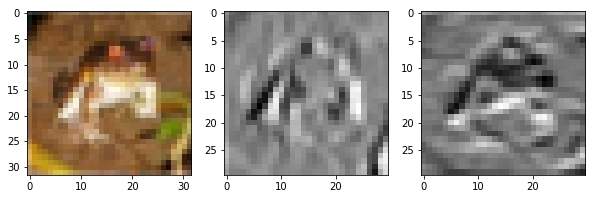

In [207]:
ys = ys.reshape(30,30,2)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,3,1)
ax.imshow(xs[0],cmap='gray')
ax = fig.add_subplot(1,3,2)
ax.imshow(ys[:,:,0],cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(ys[:,:,1],cmap='gray')
plt.show()

## 4. im2col을 통해, 풀링 연산 적용하기
---

풀링 연산도 기본적으로 합성곱 연산과 거의 동일합니다.<br>

### (1) 필터 구성하기

풀링 연산에서의 필터는 너비와 폭의 크기로 구성되어 있습니다.

In [266]:
filter_size = (2,2)
h_f, h_w = filter_size

### (2) im2col 적용하기

합성곱과 다르게, 채널 별로 max pooling을 적용해야 하기 때문에<br>
행렬의 크기를 변환하는 작업을 거칩니다.

In [280]:
_, h_in, w_in, c_in = xs.shape

stride = 2

col = im2col(xs,(h_f, h_w), stride) # 입력값을 펴줌
col = (col
       .reshape(-1,h_f, h_w,3) 
       .transpose(0,3,1,2) # 채널별로 적용하기 위해, transpose 적용
       .reshape(-1,h_f * h_w)) # 각 행 별로 patch들이 정렬되어 있음
col[:3]

array([[59., 43., 16.,  0.],
       [62., 46., 20.,  0.],
       [63., 45., 20.,  0.]])

### (3) maxpooling 적용하기

In [281]:
col = np.max(col,axis=1) # 행 별로 최댓 값 가져오기
ys = col.reshape(h_in//stride,w_in//stride,c_in)

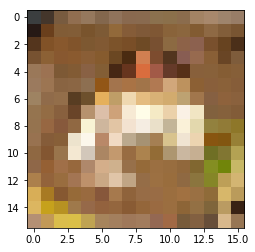

Max Pooling 적용 전 ;  (32, 32, 3)
Max Pooling 적용 후 :  (16, 16, 3)


In [282]:
ys = ys.astype(np.uint8)
plt.imshow(ys)
plt.show()

print("Max Pooling 적용 전 ; ",xs.shape[1:])
print("Max Pooling 적용 후 : ",ys.shape)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/25

---